# Setup


In [ ]:
!pip install kneed

import seaborn as sns
from scipy.stats import zscore
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import os
from google.colab import drive
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Monta Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Importazione DataSet ed unione csv


In [ ]:

#path della cartella contenente i files
csv_folder = '/content/drive/MyDrive/DataSet/GasTurbine'

#Lista dei file CSV nella cartella
csv_file = [f for f in os.listdir(csv_folder) if f.endswith(".csv")]

lista_df = []

for file in csv_file:
  file_path = os.path.join(csv_folder, file)
  df = pd.read_csv(file_path)
  lista_df.append(df)
  # lista_df length


combineddf = pd.concat(lista_df, ignore_index = True )
df = combineddf.copy()

display(df)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028
...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738


# Analisi CO e NOX


## Analisi K-means


#### Elbow-methods

[[-0.90418162  1.42649853]
 [-0.85061147  1.46289113]
 [-0.84902041  1.58268701]
 ...
 [ 3.99600838  2.64201137]
 [ 0.41585555 -0.04753021]
 [ 4.24660051  3.76316034]]


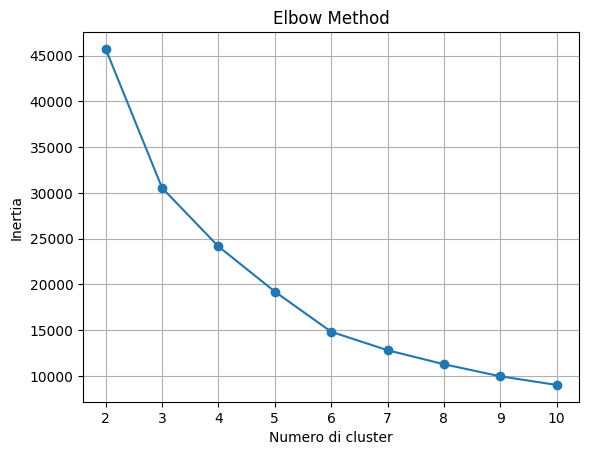

5

In [ ]:
 # Selezione di parametri
X = df[['CO', 'NOX']]

#Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#mostra X.scaled
print(X_scaled)

 #Setto i parametri
kmeans_params = {
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42
  }

  # Testa k da 2 a 10
k_values = range(2, 11)

inertias = []
for k in k_values:
  kmeans = KMeans(n_clusters=k, **kmeans_params)
  kmeans.fit(X_scaled)
  inertias.append(kmeans.inertia_)

  #Stampa il grafico
plt.plot(k_values, inertias, '-o')
plt.xlabel('Numero di cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid()
plt.show()

  # Trova il punto di gomito
knee_locator = KneeLocator(k_values, inertias, curve='convex', direction='decreasing')
elbow_point = knee_locator.elbow
display(elbow_point)


#### Esecuzione K-means

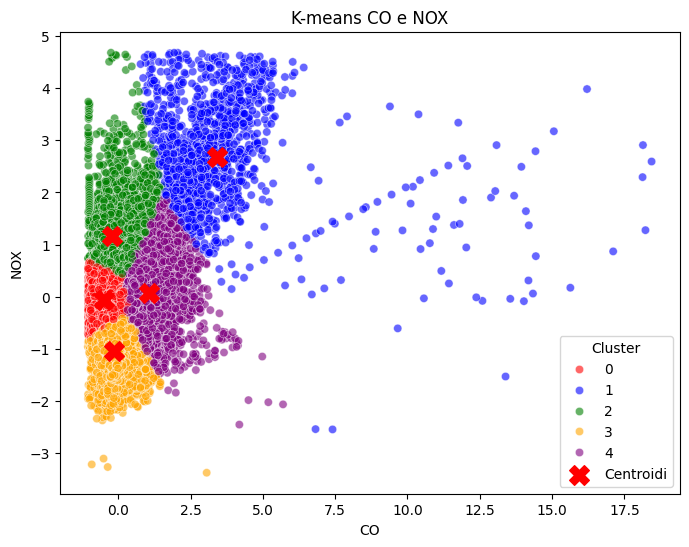

In [ ]:

#Esecuzione di kmean a 5 vie
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Definire colori personalizzati (modifica i colori a piacimento)
custom_palette = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "purple"}
centroids = kmeans.cluster_centers_


# Scatter plot con colori personalizzati
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans.labels_, palette=custom_palette, alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label="Centroidi")
plt.xlabel("CO")
plt.ylabel("NOX")
plt.title("K-means CO e NOX")
plt.legend(title="Cluster")
plt.show()


## Analisi DB-Scan

### Elbow-method per trovate eps

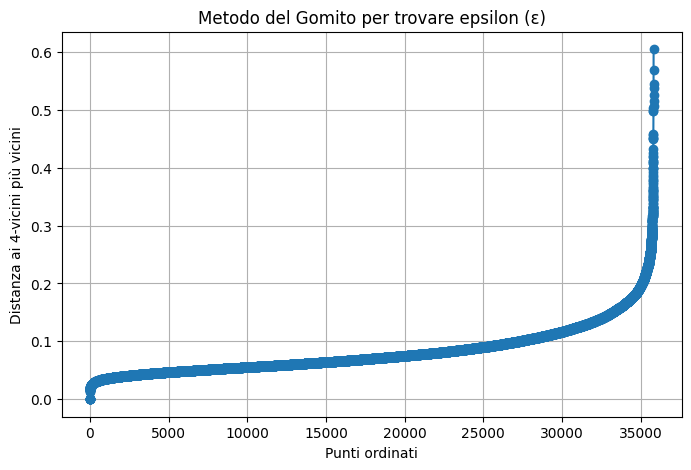

Epsilon ottimale: 0.2329


In [ ]:
# Seleziono i parametri di riferimento
X = df[["NOX", "CO"]]

# Soglia di Z-score per filtrare outlier (prova 3 o 3.5 per meno filtraggio)
z_threshold = 3

# Calcola lo Z-score per CO e NOX
z_scores = np.abs(stats.zscore(df[["CO", "NOX"]]))

# Filtriamo i dati rimuovendo gli outlier
X_filtered = df[(z_scores < z_threshold).all(axis=1)]

#Standardizzazione dei dati filtrati
X_scaled = MinMaxScaler().fit_transform(X_filtered)

#Troviamo il valore ottimale di eps usando il metodo del gomito
k = 4  # Regola empirica (2-4 volte il numero di feature)
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Ordiniamo le distanze in ordine crescente
distances = np.sort(distances[:, k-1])

# Grafico del gomito per trovare epsilon
plt.figure(figsize=(8, 5))
plt.plot(distances, marker="o", linestyle="-")
plt.xlabel("Punti ordinati")
plt.ylabel(f"Distanza ai {k}-vicini più vicini")
plt.title("Metodo del Gomito per trovare epsilon (ε)")
plt.grid()
plt.show()

# Trova il punto di gomito
knee_locator = KneeLocator(
    x=range(len(distances)),  # L'asse X deve essere la posizione dei punti
    y=distances,
    curve='convex',
    direction='increasing'  # Le distanze aumentano, quindi 'increasing'
)
elbow_point = knee_locator.elbow_y
print(f"Epsilon ottimale: {elbow_point:.4f}")

### Esecuzione del DB-Scan

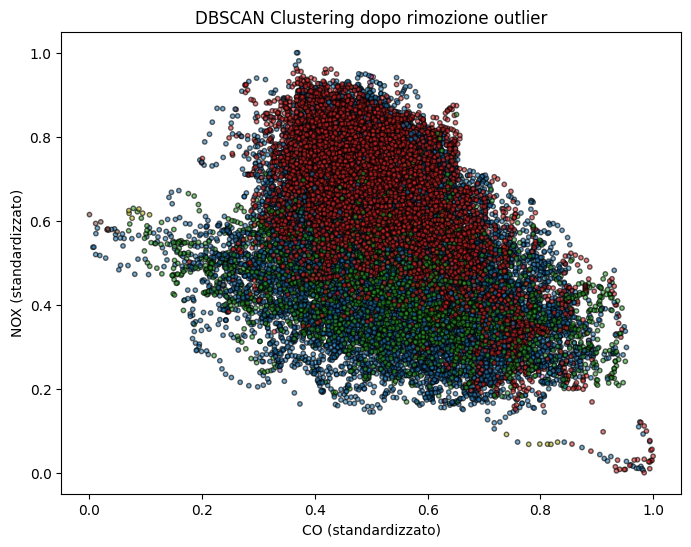

In [ ]:
#Applichiamo DBSCAN con eps calcolato
dbscan = DBSCAN(eps= 0.213, min_samples=k)
labels = dbscan.fit_predict(X_scaled)

#Plot migliorato senza outlier
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 1], X_scaled[:, 0], c=labels, cmap="tab10", alpha=0.6, edgecolors='k', s=10)
plt.xlabel("CO (standardizzato)")
plt.ylabel("NOX (standardizzato)")
plt.title("DBSCAN Clustering dopo rimozione outlier")
plt.show()

## Analisi DB-Scan

# Analisi AT AP AH

## Analisi K-means

### Elbow-method

[[-1.76236198  0.40162651]
 [-1.80191968  0.44035094]
 [-1.85411274  0.48343186]
 ...
 [-1.64229242  1.19990283]
 [-1.58835377  1.12943821]
 [-1.56747386  1.15343352]]


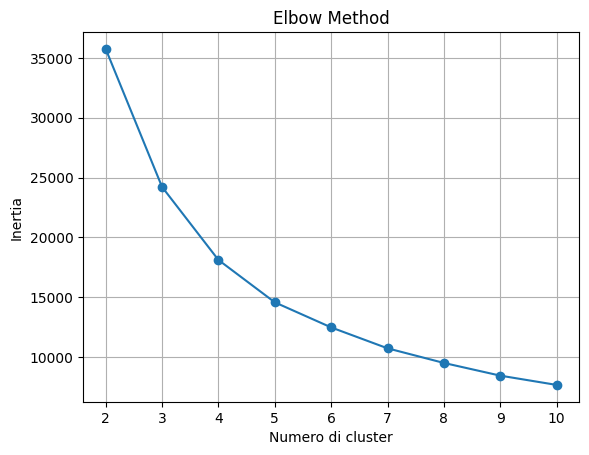

5

In [ ]:
 # Selezione di parametri
X = df[['AT',"AH"]]

#Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#mostra X.scaled
print(X_scaled)

 #Setto i parametri
kmeans_params = {
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42
  }

  # Testa k da 2 a 10
k_values = range(2, 11)

inertias = []
for k in k_values:
  kmeans = KMeans(n_clusters=k, **kmeans_params)
  kmeans.fit(X_scaled)
  inertias.append(kmeans.inertia_)

  #Stampa il grafico
plt.plot(k_values, inertias, '-o')
plt.xlabel('Numero di cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid()
plt.show()

  # Trova il punto di gomito
knee_locator = KneeLocator(k_values, inertias, curve='convex', direction='decreasing')
elbow_point = knee_locator.elbow
display(elbow_point)


### Esecuzione K-means

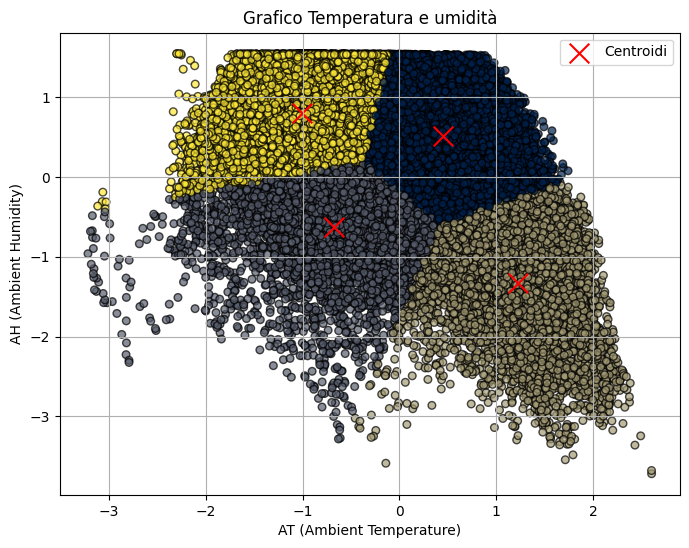

In [ ]:

# Esegui K-Means con il numero ottimale di cluster (k=4)
kmeans = KMeans(n_clusters=4, **kmeans_params)
clusters = kmeans.fit_predict(X_scaled)

# Grafico dei cluster
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='cividis', edgecolors="k", s=30, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroidi')
plt.xlabel('AT (Ambient Temperature)')
plt.ylabel('AH (Ambient Humidity)')
plt.title('Grafico Temperatura e umidità')
plt.legend()
plt.grid()
plt.show()

## Analisi DB-Scan

### Elbow Method

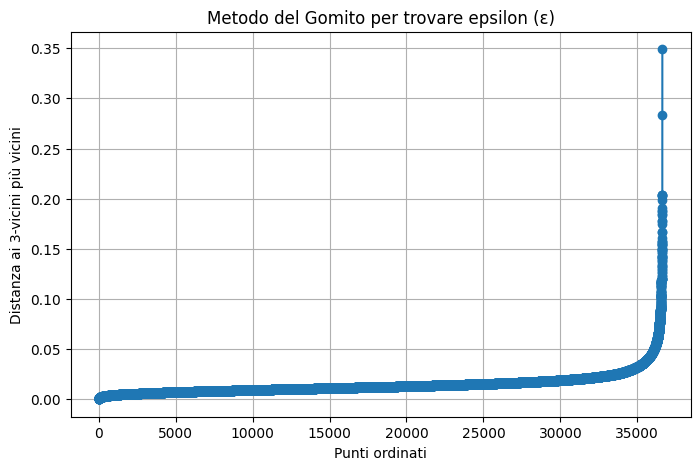

Valore ottimale di eps: 0.2036


In [ ]:
X = df[["AT", "AH"]]

  #Filtriamo gli outlier con Z-score
df['Z_AT'] = zscore(df['AT'])
df['Z_AH'] = zscore(df['AH'])
X_filtered = df[(df['Z_AT'].abs() <= 3) & (df['Z_AH'].abs() <= 3)][['AT', 'AH']]

    # Normalizziamo i dati con StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

    #Troviamo il valore ottimale di eps
k = 3
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

    #Prendiamo la distanza al k-esimo vicino
distances = np.sort(distances[:, k-1])

    #Grafico per trovare il gomito
plt.figure(figsize=(8, 5))
plt.plot(distances, marker="o", linestyle="-")
plt.xlabel("Punti ordinati")
plt.ylabel(f"Distanza ai {k}-vicini più vicini")
plt.title("Metodo del Gomito per trovare epsilon (ε)")
plt.grid()
plt.show()

    #Troviamo automaticamente il gomito con KneeLocator
knee_locator = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
optimal_eps = knee_locator.elbow_y
print(f"Valore ottimale di eps: {optimal_eps:.4f}")


### Applico DB-Scan

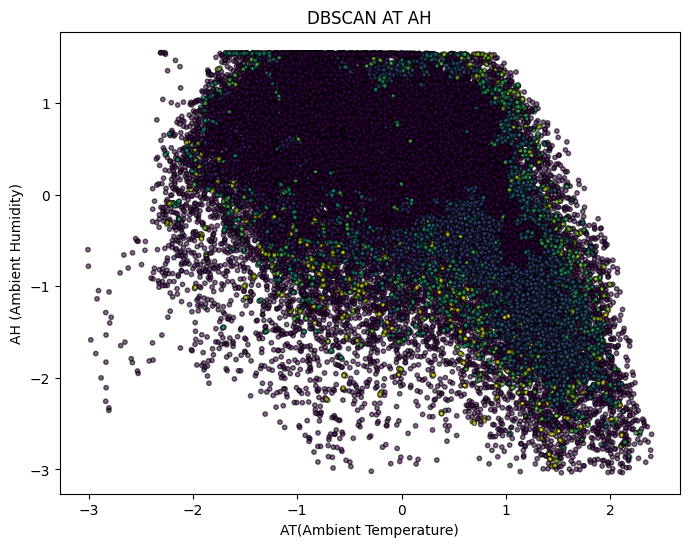

In [ ]:
dbscan = DBSCAN(eps=0.019, min_samples=k)
labels = dbscan.fit_predict(X_scaled)

#Visualizziamo il clustering su PC
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap="viridis", alpha=0.6, edgecolors='k', s=10)
plt.xlabel("AT(Ambient Temperature)")
plt.ylabel("AH (Ambient Humidity)")
plt.title("DBSCAN AT AH")
plt.show()



#Analisi TEY e TIT

## Analisi K.means


### Elbow Method

[[ 0.07450154  0.27211905]
 [ 0.07450154  0.26641654]
 [ 0.10203313  0.28922659]
 ...
 [-1.64526249 -2.47649129]
 [-0.13422633 -0.25821448]
 [-0.51838807 -0.77144048]]


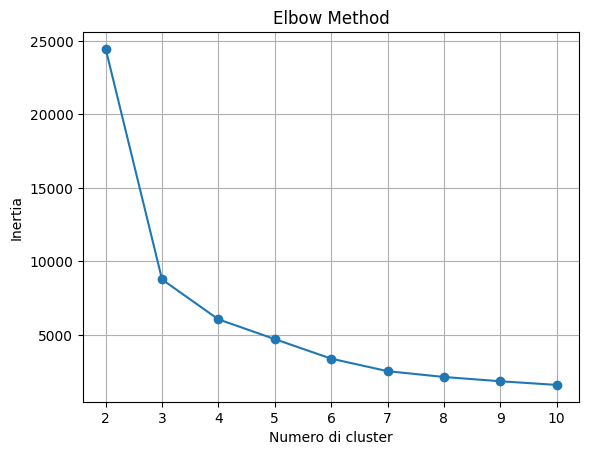

3

In [ ]:
 # Selezione di parametri
X = df[['TEY',"TIT"]]

#Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#mostra X.scaled
print(X_scaled)

 #Setto i parametri
kmeans_params = {
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42
  }

  # Testa k da 2 a 10
k_values = range(2, 11)

inertias = []
for k in k_values:
  kmeans = KMeans(n_clusters=k, **kmeans_params)
  kmeans.fit(X_scaled)
  inertias.append(kmeans.inertia_)

  #Stampa il grafico
plt.plot(k_values, inertias, '-o')
plt.xlabel('Numero di cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid()
plt.show()

  # Trova il punto di gomito
knee_locator = KneeLocator(k_values, inertias, curve='convex', direction='decreasing')
elbow_point = knee_locator.elbow
display(elbow_point)

 ### Eseguo K-means

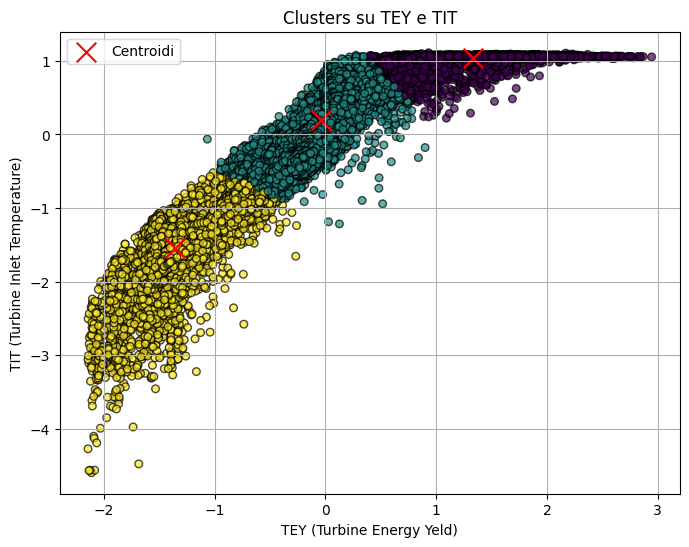

In [ ]:
# Esegui K-Means con il numero ottimale di cluster (k=4)
kmeans = KMeans(n_clusters=3, **kmeans_params)
clusters = kmeans.fit_predict(X_scaled)

# Grafico dei cluster
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.7, s= 30,edgecolor="k" )
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroidi')
plt.xlabel('TEY (Turbine Energy Yeld)')
plt.ylabel('TIT (Turbine Inlet Temperature)')
plt.title('Clusters su TEY e TIT')
plt.legend()
plt.grid()
plt.show()

## Analisi DB-Scan

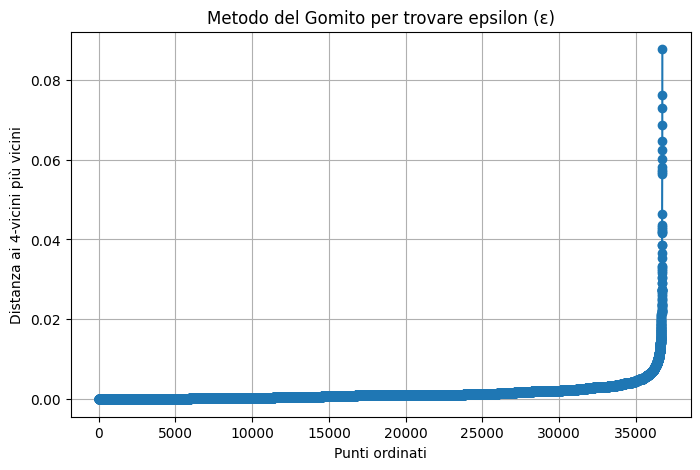

Valore ottimale di eps: 0.0140


In [ ]:
X = df[["TEY", "TIT"]]

    #Normalizziamo i dati con StandardScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

    # Troviamo il valore ottimale di eps
k = 4
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

    #Prendiamo la distanza al k-esimo vicino
distances = np.sort(distances[:, k-1])

    #Grafico per trovare il gomito
plt.figure(figsize=(8, 5))
plt.plot(distances, marker="o", linestyle="-")
plt.xlabel("Punti ordinati")
plt.ylabel(f"Distanza ai {k}-vicini più vicini")
plt.title("Metodo del Gomito per trovare epsilon (ε)")
plt.grid()
plt.show()

    #Troviamo automaticamente il gomito con KneeLocator
knee_locator = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
optimal_eps = knee_locator.elbow_y
print(f"Valore ottimale di eps: {optimal_eps:.4f}")

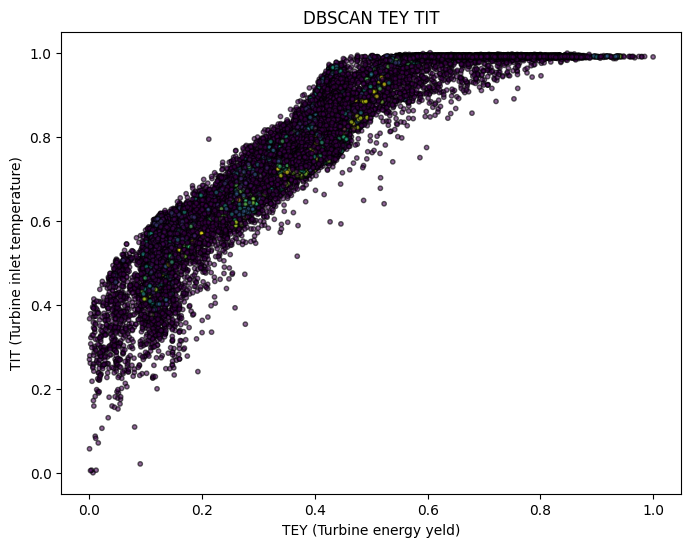

In [ ]:
dbscan = DBSCAN(eps=0.0020, min_samples=k)
labels = dbscan.fit_predict(X_scaled)

#Visualizziamo il clustering su PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap="viridis", alpha=0.6, edgecolors='k', s=10)
plt.xlabel("TEY (Turbine energy yeld)")
plt.ylabel("TIT (Turbine inlet temperature)")
plt.title("DBSCAN TEY TIT")
plt.show()

